In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

# import

In [2]:
from ..exp import databunch
from ..exp import resnet_ssd
from ..exp import interpretation
from ..exp import anchors_loss_metrics

In [3]:
from fastai.basic_train import Learner

In [4]:
import torch

In [5]:
from torch import tensor

In [6]:
import sys

In [7]:
import cv2

In [8]:
from functools import partial

In [9]:
import re
import os

# functions

## get_model_size

In [10]:
# 看看这个模型有多少参数，占多少内存
def get_model_size(model):
    '统计并打印模型的参数个数和占内存大小'
    cnt = 0
    msize = 0
    
    for v in model.parameters():
        cnt += v.data.nelement()
        msize += v.data.nelement()*v.data.element_size()
    print('{:.2f}M个参数，{:.2f}Mbyte'.format(cnt/1024/1024,msize/1024/1024))
    
    return cnt,msize

## Normalizer

In [11]:
class Normalizer():
    def __init__(self,mean,std,device):
        self.mean = mean.to(device)
        self.std = std.to(device)
        
    def __call__(self,x):
        res = x/255
        res = (res-self.mean)/self.std
        return res

## all image file names in a folder

In [12]:
tail_pat = re.compile(r'^.*\.(\w+)$')
def img_names(fold_path):
    res = []
    
    fnames = list(map(lambda fn: fold_path+fn, os.listdir(fold_path)))
    for fname in fnames:
        tail = tail_pat.findall(fname)
        if len(tail)==1 and (tail[0] in ['png', 'jpg']):
            res += [fname]
    
    return res

# test

## 导出pkl

In [13]:
device = torch.device('cuda', 1)

In [14]:
def pth2pkl(pth_file,pkl_file):
    # 创建learn并加载训练好的checkpoint
    data = databunch.get_databunch(data_root='./data/ds_20200227') 
    #model = resnet_ssd.get_resnet18_1ssd()
    model = resnet_ssd.get_resnet18_1ssd_2()
    learn = Learner(data,model)
    with open(pth_file,'rb') as f:
        learn.load(f)
        
    # 把模型状态导出为pkl
    with open(pkl_file,'wb') as f:
        learn.export(f)

In [15]:
pth_file = './run_log/yanke/run_0.pth'
pkl_file = './run_log/yanke/run_0.pkl'

In [16]:
# 改行代码不需要重复执行，若已有pkl文件，则无需执行
# pth2pkl(pth_file,pkl_file)

## 准备

### 载入pkl，提取信息

In [17]:
with open(pkl_file,'rb') as f:
    state = torch.load(f, map_location='cuda')

In [18]:
# 看看pkl文件里都保存了什么
state.keys()

dict_keys(['opt_func', 'loss_func', 'metrics', 'true_wd', 'bn_wd', 'wd', 'train_bn', 'model_dir', 'callback_fns', 'cb_state', 'model', 'data', 'cls'])

In [19]:
# 提取模型
model = state['model']
if hasattr(model, "module"):
    model = model.module

In [20]:
# 看看模型有多大
get_model_size(model)

10.91M个参数，43.63Mbyte


(11437246, 45748984)

In [21]:
# 提取与输入输出处理有关的参数
normMean = state['data']['normalize']['mean']
normStd = state['data']['normalize']['std']
classes = state['data']['y_proc'][0].classes[1:]

### 准备模型和各种处理函数

In [22]:
# 设置你在哪里运行模型，cpu/cuda
device = torch.device('cuda', 0)

In [23]:
# 把模型放到device上，如果使用GPU，则设置使用哪几个GPU
if hasattr(model, "module"): 
    model = model.module

model.to(device);

if device.type=='cuda':
    model = torch.nn.DataParallel(model,device_ids=[0,1,2,3])

In [24]:
# 把模型设置为eval模式，防止其batchnorm状态发生变化
model.eval();
model.training

False

In [25]:
# 输入图片需要经normalize才能给到模型输入，这是做normalize的函数
normalize = Normalizer(mean=normMean[None,:,None,None],
                       std=normStd[None,:,None,None],
                       device=device)

In [26]:
# 解析模型输出需要用到grid-anchor的设置
gvs,_,_,avs,_,_ = anchors_loss_metrics.get_ga666()
gaf = anchors_loss_metrics.GridAnchor_Funcs(gvs,avs,device)

In [74]:
# 把模型输出处理为最终预测结果的函数
out2pred = partial(interpretation.netouts2preds, gaf=gaf,
                                                    composeConfPrb=True,
                                                    filt_thres=0.95,
                                                    ov_thres=0.05,
                                                    despiteCat=True)

## 推理

In [69]:
# 读入图片
root_path = './data/test/'
fns = img_names(root_path)

imgs = []
for fn in fns:
    img = cv2.imread(fn).transpose(2,0,1)
    imgs += [tensor(img).unsqueeze(0)]
imgs = torch.cat(imgs,0)

In [75]:
# 图片做normalize，得到模型输入
netin = normalize(imgs.float().to(device))

In [76]:
# 模型输出
with torch.no_grad():
    netout = model(netin)

In [77]:
# 处理模型输出得到预测结果
b_boxs, b_confs, b_cats, b_prbs, b_f1s = out2pred(netout)

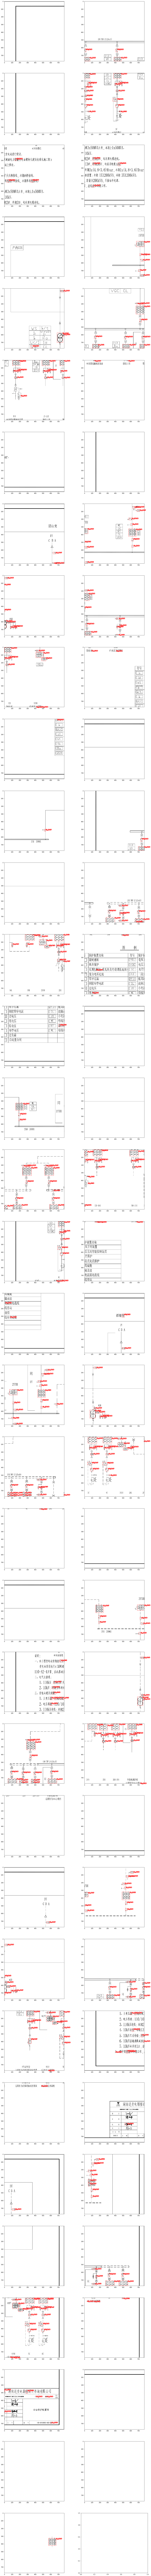

In [78]:
# 预测结果可视化
interpretation.show_batch_pred(imgs,
                                  b_boxs,
                                  b_cats,
                                  b_f1s,
                                  classes=classes)